# Table of Contents
* [Inference framework for for spatial segregation](#Inference-framework-for-for-spatial-segregation)
	* [Importing Dependencies](#Importing-Dependencies)
	* [Defining a function that returns segregation measures](#Defining-a-function-that-returns-segregation-measures)
	* [Defining the Segregation iterations under null hypothesis for a specific space-time](#Defining-the-Segregation-iterations-under-null-hypothesis-for-a-specific-space-time)
	* [Reading the dataset](#Reading-the-dataset)
		* [Probability under the null hypothesis](#Probability-under-the-null-hypothesis)
	* [Eveness null approach](#Eveness-null-approach)
		* [Calculating the estimated value and the simulations](#Calculating-the-estimated-value-and-the-simulations)
		* [Ploting the results](#Ploting-the-results)
	* [Permutation null approach](#Permutation-null-approach)
		* [Calculating the estimated value and the simulations](#Calculating-the-estimated-value-and-the-simulations)
		* [Plotting the results](#Plotting-the-results)
	* [Eveness with Permutation null approach](#Eveness-with-Permutation-null-approach)
		* [Calculating the estimated value and the simulations](#Calculating-the-estimated-value-and-the-simulations)
		* [Plotting the results](#Plotting-the-results)
* [Comparing two counties: was Riverside, significantly, more or less segregated than San Bernardino in 2010?](#Comparing-two-counties:-was-Riverside,-significantly,-more-or-less-segregated-than-San-Bernardino-in-2010?)
	* [Random Geometry Labelling Approach](#Random-Geometry-Labelling-Approach)
	* [Random Data Approach](#Random-Data-Approach)
* [Comparing same county between two distincts periods in time: was Riverside, significantly, more or less segregated in 2010 than itself in 2000?](#Comparing-same-county-between-two-distincts-periods-in-time:-was-Riverside,-significantly,-more-or-less-segregated-in-2010-than-itself-in-2000?)


# Inference framework for for spatial segregation

All the data and supplementary files can be found at: https://github.com/renanxcortes/inequality-segregation-supplementary-files

## Importing Dependencies

In [1]:
import pandas as pd
import pysal as ps
import geopandas as gpd
import scipy
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from scipy.ndimage.interpolation import shift

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
os.chdir('C:/Users/renan/Desktop/inequality-segregation-supplementary-files/')

## Defining a function that returns segregation measures

In [3]:
def calculate_segregation(data, group_pop_var, total_pop_var):
    '''
    data: a geopandas DataFrame that contains a geometry column
    group_pop_var: the name of variable that contains the population size of the group of interest
    total_pop_var: the name of variable that contains the total population of the unit
    '''
    
    # Uneveness
    data = data.rename(columns={group_pop_var: 'group_pop_var', total_pop_var: 'total_pop_var'})
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    data = data.assign(xi = data.group_pop_var,
                       yi = data.total_pop_var - data.group_pop_var,
                       ti = data.total_pop_var,
                       pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))
    D = (((data.total_pop_var * abs(data.pi - P)))/ (2 * T * P * (1 - P))).sum()
    
    
    num = (np.matmul(np.array(data.ti)[np.newaxis].T, np.array(data.ti)[np.newaxis]) * abs(np.array(data.pi)[np.newaxis].T - np.array(data.pi)[np.newaxis])).sum()
    den = (2 * T**2 * P * (1-P))
    G = num / den
    G
    
    E = P * np.log(1 / P) + (1 - P) * np.log(1 / (1 - P))
    Ei = data.pi * np.log(1 / data.pi) + (1 - data.pi) * np.log(1 / (1 - data.pi))
    H = (data.ti * (E - Ei) / (E * T)).sum()
    H
    
    # Isolation
    X = data.xi.sum()
    Y = data.yi.sum()
    xPx = ((data.xi / X) * (data.xi / data.ti)).sum()
    xPy = ((data.xi / X) * (data.yi / data.ti)).sum()
    yPy = ((data.yi / Y) * (data.yi / data.ti)).sum()
    
    CISO = xPx - X/T
    RI = xPx/yPy
    
    # Clustering
    data = data.assign(c_lons = data.centroid.map(lambda p: p.x),
                       c_lats = data.centroid.map(lambda p: p.y))
    dist = euclidean_distances(data[['c_lons','c_lats']])
    np.fill_diagonal(dist, val = (0.6*data.area)**(1/2))
    c = np.exp(-dist)
    Pxx = ((np.array(data.xi) * c).T * np.array(data.xi)).sum() / X**2
    Pyy = ((np.array(data.yi) * c).T * np.array(data.yi)).sum() / Y**2
    Ptt = ((np.array(data.ti) * c).T * np.array(data.ti)).sum() / T**2
    
    SP = (X*Pxx + Y*Pyy)/(T*Ptt)
    RCL = Pxx / Pyy - 1

    # Concentration
    A = data.area.sum()
    DEL = 1/2 * abs(data.xi / X - data.area / A).sum()
    
    df_mp_sort_area = data
    df_mp_sort_area = df_mp_sort_area.assign(area = df_mp_sort_area.area)
    df_mp_sort_area_asc = df_mp_sort_area.sort_values('area')
    n1 = np.where(((np.cumsum(df_mp_sort_area_asc.ti) / T) < X/T) == False)[0][0]
    
    df_mp_sort_area_des = df_mp_sort_area.sort_values('area', ascending=False)
    n2 = np.where(((np.cumsum(df_mp_sort_area_des.ti) / T) < X/T) == False)[0][0]
    
    n = df_mp_sort_area_asc.shape[0]
    T1 =  df_mp_sort_area_asc.ti[0:(n1+1)].sum()
    T2 =  df_mp_sort_area_asc.ti[n2:n].sum()

    RCO = ((((df_mp_sort_area_asc.xi*df_mp_sort_area_asc.area/X).sum()) / ((df_mp_sort_area_asc.yi*df_mp_sort_area_asc.area/Y).sum())) - 1) / \
          ((((df_mp_sort_area_asc.ti*df_mp_sort_area_asc.area)[0:(n1+1)].sum() / T1) / ((df_mp_sort_area_asc.ti*df_mp_sort_area_asc.area)[n2:n].sum() / T2)) - 1)


    
    # Centralization
    data = data.assign(center_lon = data.c_lons.mean(),
                       center_lat = data.c_lats.mean())
    data['center_dist'] = np.sqrt((data.c_lons - data.center_lon)**2 + (data.c_lats - data.center_lat)**2)
    data_sort_cent = data.sort_values('center_dist')
    
    data_sort_cent = data_sort_cent.assign(Xi = np.cumsum(data_sort_cent.xi) / X,
                                           Yi = np.cumsum(data_sort_cent.yi) / Y,
                                           Ai = np.cumsum(data_sort_cent.area) / A)
    
    ACE = (shift(data_sort_cent.Xi, 1, cval=np.NaN) * data_sort_cent.Ai).sum() - \
          (data_sort_cent.Xi * shift(data_sort_cent.Ai, 1, cval=np.NaN)).sum()
    
    RCE = (shift(data_sort_cent.Xi, 1, cval=np.NaN) * data_sort_cent.Yi).sum() - \
          (data_sort_cent.Xi * shift(data_sort_cent.Yi, 1, cval=np.NaN)).sum()
    
    # Aggregating
    SM = np.mean([D, CISO, RCL, RCO, RCE])
    
    return {'Dissimilarity (D)': D, 
            'Gini (G)': G,
            'Entropy (H)': H,
            
            'Isolation (xPx)': xPx, 
            'Exposure (xPy)': xPy, 
            'Centralized Isolation (CISO)': CISO,
            'Relative Isolation (RI)': RI,
            
            'Spatial Proximity (clustering) (SP)': SP, 
            'Relative Clustering (RCL)': RCL, 
            
            'Delta (concentration) (DEL)': DEL,
            'Relative Concentration (RCO)': RCO,
            
            'Absolute Centralization (ACE)': ACE,
            'Relative Centralization (RCE)': RCE,
            
            'Overall Segregation Measure (SM)': SM
           }

## Defining the Segregation iterations under null hypothesis for a specific space-time

In [4]:
def infer_segregation(data, 
                      group_pop_var, 
                      total_pop_var, 
                      iterations = 1000,
                      null_approach = "eveness"):
    '''
    data: a geopandas DataFrame that contains a geometry column
    group_pop_var: the name of variable that contains the population size of the group of interest
    total_pop_var: the name of variable that contains the total population of the unit
    iterations: number of iterations to compute inference on pseudo p-values
    null_approach: argument that specifies which type of null hyphotesis the inference will iterate. 
        "eveness": establish that each spatial unit would have the same global probability of drawing elements from the minority group of the fixed total unit population. 
        "permutation": randomly allocates the units over space keeping the sample values fixed.
        "even_permutation": randomly allocates the units over space and assuming the same global probability of drawning elements from the minority group in each spatial unit.
    '''
    
    data = data.rename(columns={group_pop_var: 'group_pop_var', total_pop_var: 'total_pop_var'})
    p_null = data.group_pop_var.sum() / data.total_pop_var.sum()
    
    Ds    = np.empty(iterations)
    Gs    = np.empty(iterations)
    Hs    = np.empty(iterations)
    
    xPxs  = np.empty(iterations)
    xPys  = np.empty(iterations)
    CISOs = np.empty(iterations)
    RIs   = np.empty(iterations)
    
    SPs   = np.empty(iterations)
    RCLs  = np.empty(iterations)
    
    DELs  = np.empty(iterations)
    RCOs  = np.empty(iterations)
    
    ACEs  = np.empty(iterations)
    RCEs  = np.empty(iterations)
    
    SMs   = np.empty(iterations)
    
    local_RCEs   = np.empty(data.shape[0])
    
    if (null_approach == "eveness"):
        for i in np.array(range(iterations)):
            
            freq_sim = np.random.binomial(n = np.array([data.total_pop_var.tolist()]), 
                                          p = np.array([[p_null]*data.shape[0]]), 
                                          size = (1, data.shape[0])).tolist()[0]
            data = data.assign(group_pop_var = freq_sim)
            test = calculate_segregation(data, 'group_pop_var', 'total_pop_var')
            Ds[i] = list(test.values())[0]
            Gs[i] = list(test.values())[1]
            Hs[i] = list(test.values())[2]

            xPxs[i] = list(test.values())[3]
            xPys[i] = list(test.values())[4]
            CISOs[i] = list(test.values())[5]
            RIs[i] = list(test.values())[6]

            SPs[i] = list(test.values())[7]
            RCLs[i] = list(test.values())[8]

            DELs[i] = list(test.values())[9]
            RCOs[i] = list(test.values())[10]

            ACEs[i] = list(test.values())[11]
            RCEs[i] = list(test.values())[12]

            SMs[i] = list(test.values())[13]
            

    if (null_approach == "permutation"):
        for i in range(iterations):

            data = data.assign(geometry = data.geometry[list(np.random.choice(data.shape[0], data.shape[0], replace = False))].reset_index()['geometry'])
            test = calculate_segregation(data, 'group_pop_var', 'total_pop_var')
            Ds[i] = list(test.values())[0]
            Gs[i] = list(test.values())[1]
            Hs[i] = list(test.values())[2]

            xPxs[i] = list(test.values())[3]
            xPys[i] = list(test.values())[4]
            CISOs[i] = list(test.values())[5]
            RIs[i] = list(test.values())[6]

            SPs[i] = list(test.values())[7]
            RCLs[i] = list(test.values())[8]

            DELs[i] = list(test.values())[9]
            RCOs[i] = list(test.values())[10]

            ACEs[i] = list(test.values())[11]
            RCEs[i] = list(test.values())[12]

            SMs[i] = list(test.values())[13]
            
    if (null_approach == "even_permutation"):
        for i in range(iterations):
            
            freq_sim = np.random.binomial(n = np.array([data.total_pop_var.tolist()]), 
                                          p = np.array([[p_null]*data.shape[0]]), 
                                          size = (1, data.shape[0])).tolist()[0]
            data = data.assign(group_pop_var = freq_sim,
                               geometry = data.geometry[list(np.random.choice(data.shape[0], data.shape[0], replace = False))].reset_index()['geometry'])
            test = calculate_segregation(data, 'group_pop_var', 'total_pop_var')
            Ds[i] = list(test.values())[0]
            Gs[i] = list(test.values())[1]
            Hs[i] = list(test.values())[2]

            xPxs[i] = list(test.values())[3]
            xPys[i] = list(test.values())[4]
            CISOs[i] = list(test.values())[5]
            RIs[i] = list(test.values())[6]

            SPs[i] = list(test.values())[7]
            RCLs[i] = list(test.values())[8]

            DELs[i] = list(test.values())[9]
            RCOs[i] = list(test.values())[10]

            ACEs[i] = list(test.values())[11]
            RCEs[i] = list(test.values())[12]

            SMs[i] = list(test.values())[13]
    
    
    return Ds, Gs, Hs, xPxs, xPys, CISOs, RIs, SPs, RCLs, DELs, RCOs, ACEs, RCEs, SMs
    

## Reading the dataset

In [5]:
census_2010 = pd.read_csv("data/std_2010_fullcount.csv", encoding = "ISO-8859-1", sep = ",")
map_gpd =  gpd.read_file('Tracts_grouped_by_County/06065.json')
#map_gpd =  gpd.read_file('Tracts_grouped_by_County/01005.json')
map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
df_map = map_gpd.merge(census_2010, left_on = 'INTGEOID10', right_on = 'trtid10')
df_mp = df_map[['geometry', 'pop10', 'nhblk10']]
df_mp.head()

,geometry,pop10,nhblk10
0,"POLYGON ((-117.319414 33.902109, -117.322528 3...",6242,677
1,"POLYGON ((-117.504056 33.800257, -117.502758 3...",10258,844
2,"POLYGON ((-117.472451 33.762031, -117.475661 3...",6342,405
3,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",2594,346
4,"POLYGON ((-117.501299 33.89424899999999, -117....",3586,429


In [6]:
test = calculate_segregation(df_mp, 'nhblk10', 'pop10')
test

{'Dissimilarity (D)': 0.31565682496226544,
 'Gini (G)': 0.44620350030600087,
 'Entropy (H)': 0.08636489348167173,
 'Isolation (xPx)': 0.11321482777341298,
 'Exposure (xPy)': 0.886785172226587,
 'Centralized Isolation (CISO)': 0.04541375901373959,
 'Relative Isolation (RI)': 0.12102040382673805,
 'Spatial Proximity (clustering) (SP)': 1.002191883006537,
 'Relative Clustering (RCL)': 0.12418089857347714,
 'Delta (concentration) (DEL)': 0.8367330649317353,
 'Relative Concentration (RCO)': 0.5364305924831142,
 'Absolute Centralization (ACE)': 0.6416113799795511,
 'Relative Centralization (RCE)': 0.18550429720565376,
 'Overall Segregation Measure (SM)': 0.24143727444765}

### Probability under the null hypothesis

In [7]:
p_null = df_mp.nhblk10.sum() / df_mp.pop10.sum()
p_null

0.06780106875967339

In [8]:
actual_value = calculate_segregation(df_mp, 'nhblk10', 'pop10')

## Eveness null approach

### Calculating simulations

In [9]:
simulations_even =  infer_segregation(df_mp, 'nhblk10', 'pop10', iterations = 500, null_approach = "eveness")

### Ploting the results

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


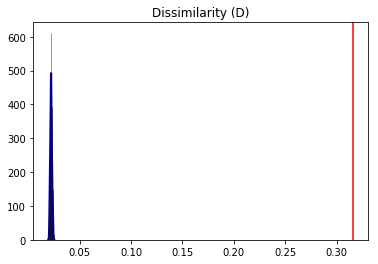

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


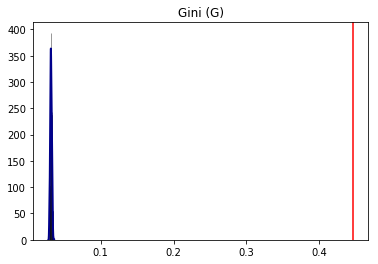

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


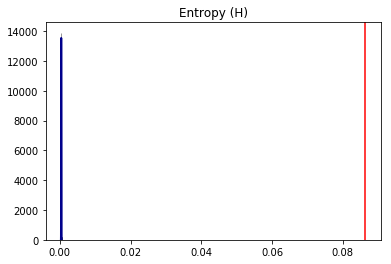

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


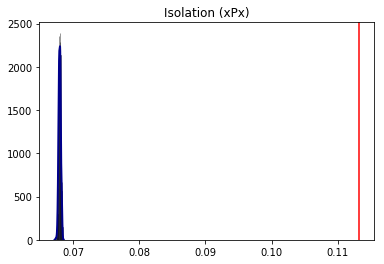

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


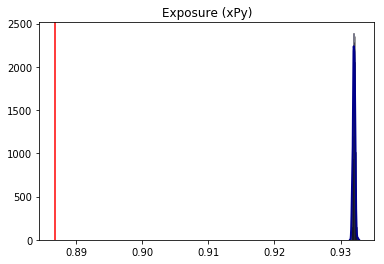

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


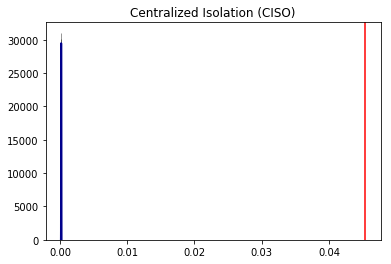

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


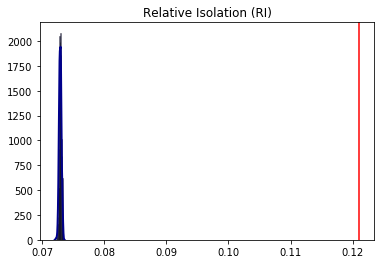

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


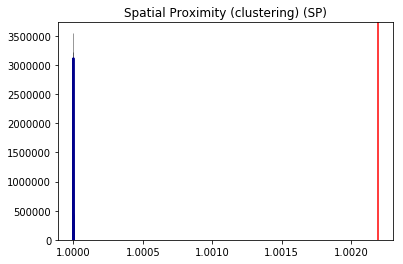

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


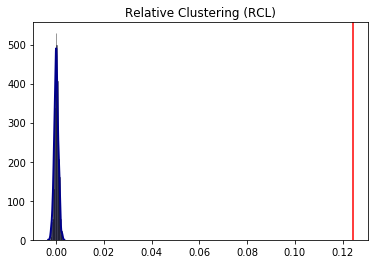

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


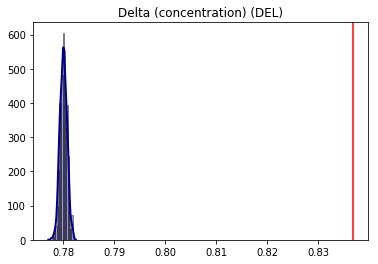

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


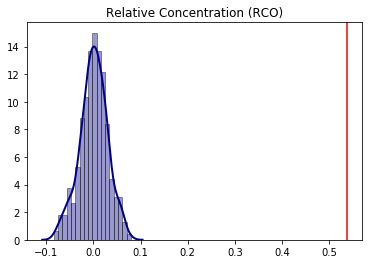

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


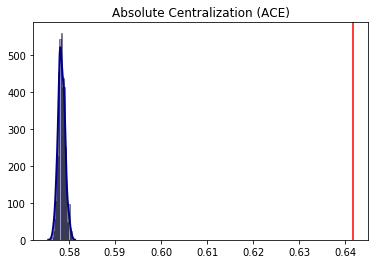

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


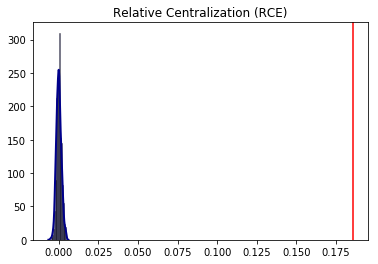

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


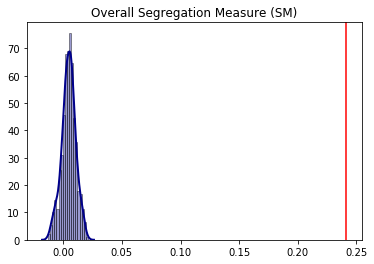

In [10]:
for i in range(len(simulations_even)):
    sns.distplot(simulations_even[i], 
                 hist=True, 
                 #kde=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    #plt.axvline(0, color = 'green')
    plt.axvline(list(actual_value.values())[i], color = 'red')
    plt.title(list(actual_value.keys())[i])
    plt.show()

## Permutation null approach

### Calculating simulations

In [11]:
simulations_perm =  infer_segregation(df_mp, 'nhblk10', 'pop10', iterations = 500, null_approach = "permutation")

### Plotting the results

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


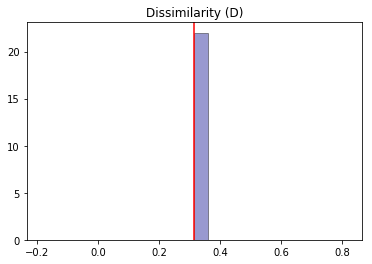

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


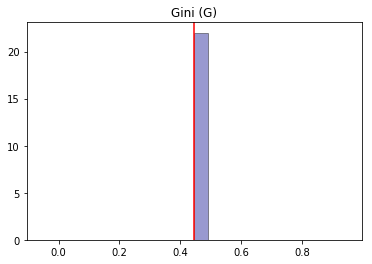

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


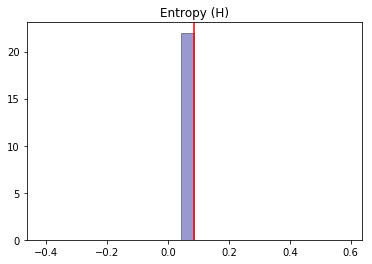

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


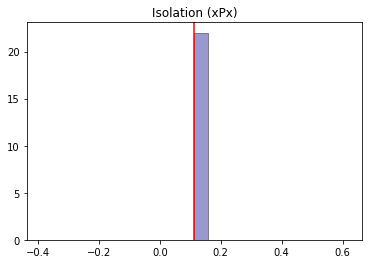

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


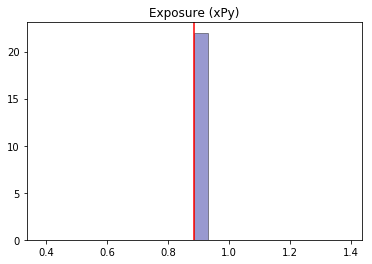

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


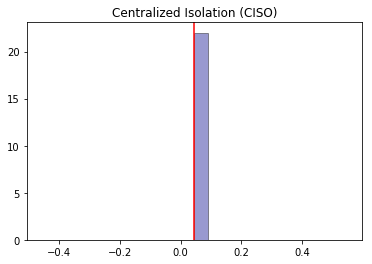

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


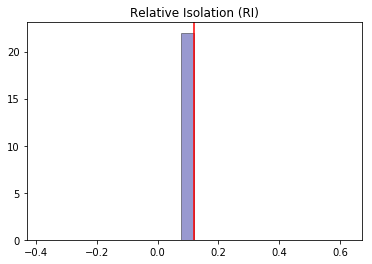

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


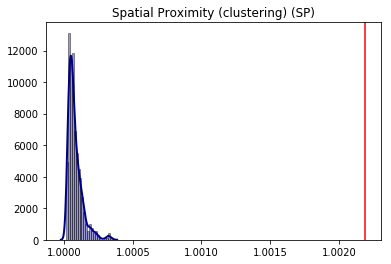

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


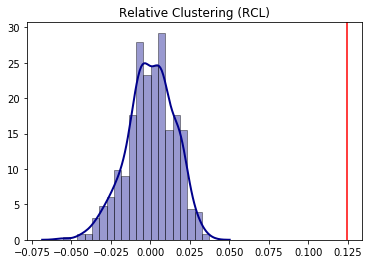

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


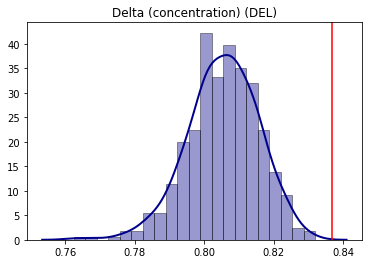

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


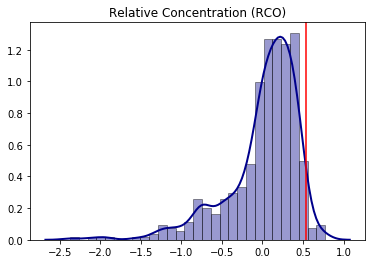

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


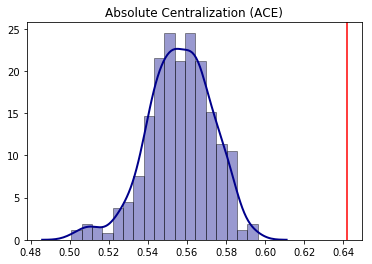

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


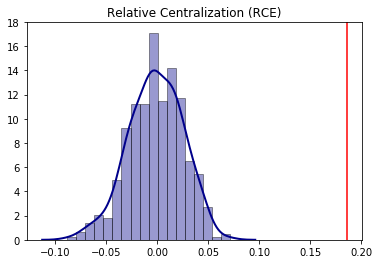

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


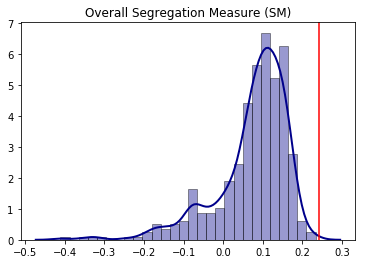

In [12]:
for i in range(len(simulations_perm)):
    sns.distplot(simulations_perm[i], 
                 hist=True, 
                 #kde=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    #plt.axvline(0, color = 'green')
    plt.axvline(list(actual_value.values())[i], color = 'red')
    plt.title(list(actual_value.keys())[i])
    plt.show()

## Eveness with Permutation null approach

### Calculating simulations

In [13]:
simulations_even_perm =  infer_segregation(df_mp, 'nhblk10', 'pop10', iterations = 500, null_approach = "even_permutation")

### Plotting the results

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


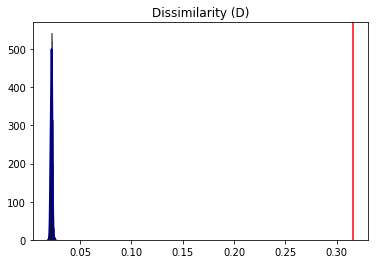

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


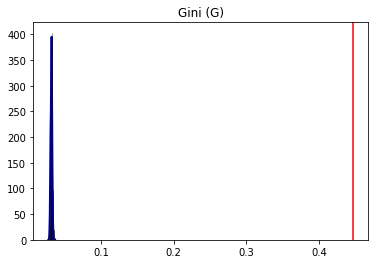

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


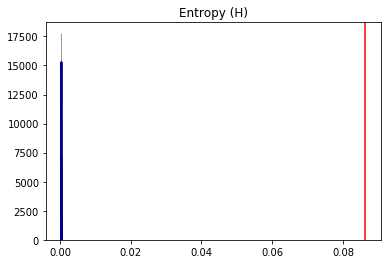

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


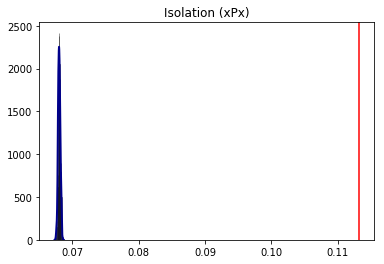

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


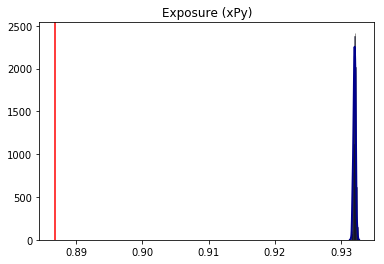

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


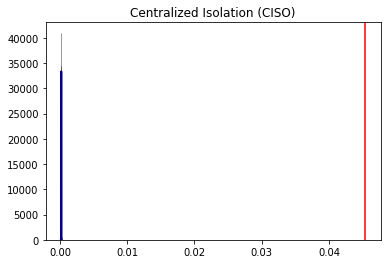

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


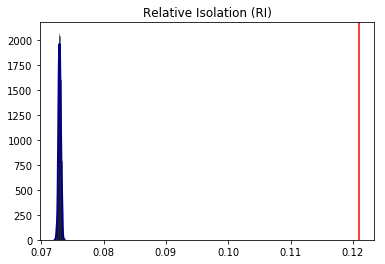

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


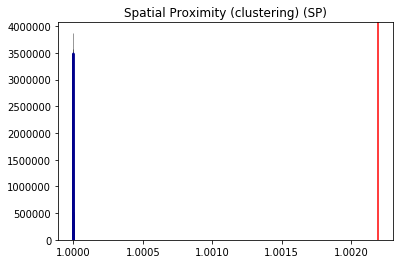

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


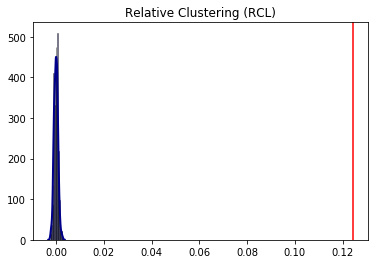

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


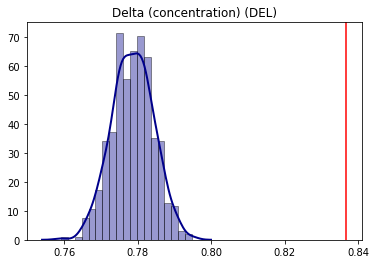

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


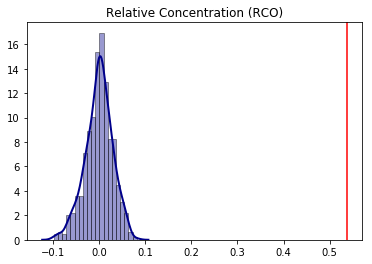

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


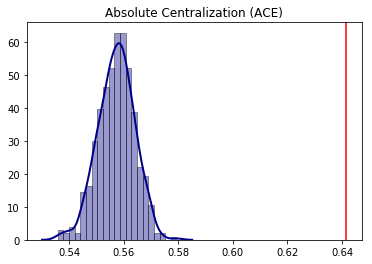

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


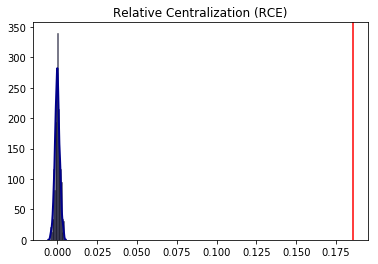

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


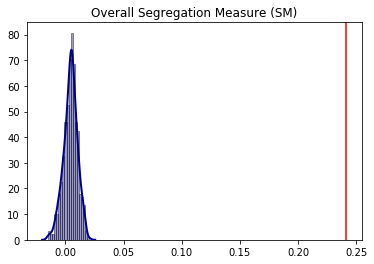

In [14]:
for i in range(len(simulations_even_perm)):
    sns.distplot(simulations_even_perm[i], 
                 hist=True, 
                 #kde=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    #plt.axvline(0, color = 'green')
    plt.axvline(list(actual_value.values())[i], color = 'red')
    plt.title(list(actual_value.keys())[i])
    plt.show()

# Comparing two counties: was Riverside, significantly, more or less segregated than San Bernardino in 2010? 

## Random Geometry Labelling Approach

In [15]:
map1_gpd = gpd.read_file('Tracts_grouped_by_County/06065.json')
map2_gpd = gpd.read_file('Tracts_grouped_by_County/06071.json')

map1_gpd['INTGEOID10'] = pd.to_numeric(map1_gpd["GEOID10"])
map2_gpd['INTGEOID10'] = pd.to_numeric(map2_gpd["GEOID10"])

df_map1 = map1_gpd.merge(census_2010, left_on = 'INTGEOID10', right_on = 'trtid10')[['geometry', 'nhblk10', 'pop10']]
df_map2 = map2_gpd.merge(census_2010, left_on = 'INTGEOID10', right_on = 'trtid10')[['geometry', 'nhblk10', 'pop10']]

actual_values_A = calculate_segregation(df_map1, 'nhblk10', 'pop10')
actual_values_B = calculate_segregation(df_map2, 'nhblk10', 'pop10')

df_map1['region'] = 'A'
df_map2['region'] = 'B'

stacked_df_map = pd.concat([df_map1, df_map2], ignore_index=True)

aux_rand = list(np.random.choice(stacked_df_map.shape[0], stacked_df_map.shape[0], replace = False))

stacked_df_map['rand_region'] = stacked_df_map.region[aux_rand].reset_index()['region']
stacked_df_map['rand_pop10'] = stacked_df_map.pop10[aux_rand].reset_index()['pop10']
stacked_df_map['rand_nhblk10'] = stacked_df_map.nhblk10[aux_rand].reset_index()['nhblk10']

stacked_df_map.head()

,geometry,nhblk10,pop10,region,rand_region,rand_pop10,rand_nhblk10
0,"POLYGON ((-117.319414 33.902109, -117.322528 3...",677,6242,A,B,6752,181
1,"POLYGON ((-117.504056 33.800257, -117.502758 3...",844,10258,A,A,3477,100
2,"POLYGON ((-117.472451 33.762031, -117.475661 3...",405,6342,A,A,2907,102
3,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",346,2594,A,A,5025,232
4,"POLYGON ((-117.501299 33.89424899999999, -117....",429,3586,A,B,7444,399


Splitting the stacked data frames in the new labelled regions and calculating the simulation for each chunk: random geometry approach.

In [16]:
stacked_df_map_RG_A = stacked_df_map.loc[stacked_df_map['rand_region'] == 'A']
stacked_df_map_RG_B = stacked_df_map.loc[stacked_df_map['rand_region'] == 'B']

simulations_A =  infer_segregation(stacked_df_map_RG_A, 'nhblk10', 'pop10', iterations = 250)
simulations_B =  infer_segregation(stacked_df_map_RG_B, 'nhblk10', 'pop10', iterations = 250)

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


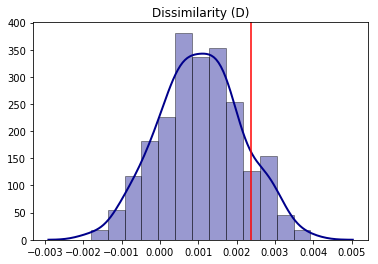

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


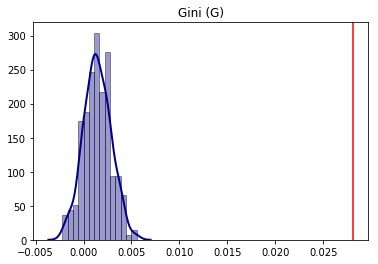

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


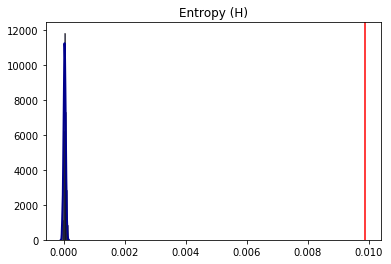

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


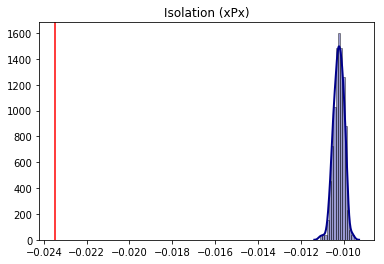

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


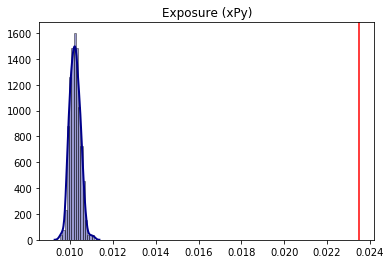

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


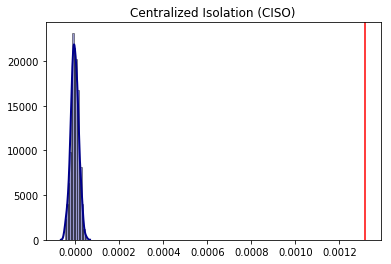

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


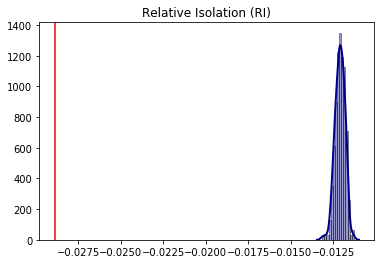

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


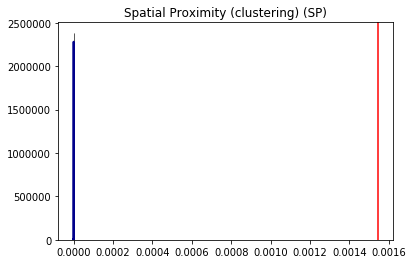

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


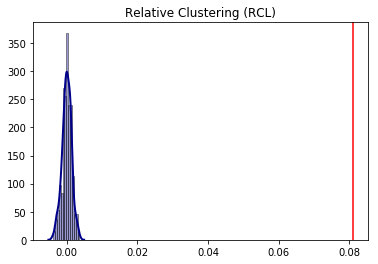

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


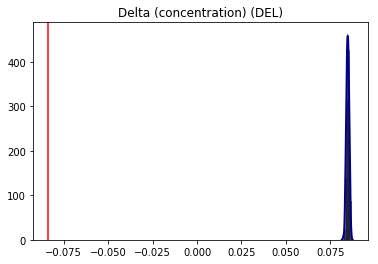

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


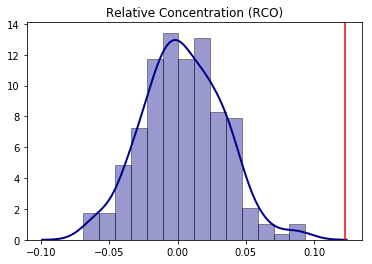

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


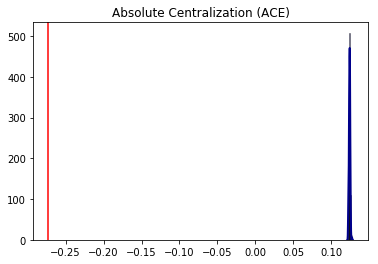

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


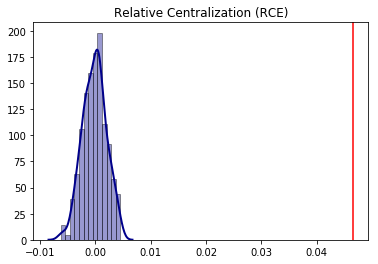

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


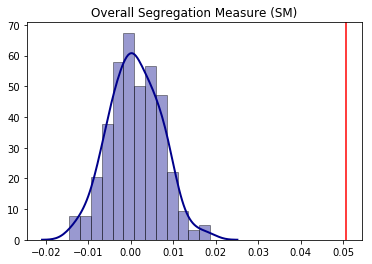

In [17]:
for i in range(len(simulations_A)):
    sns.distplot(np.array(simulations_A[i]) - np.array(simulations_B[i]), 
                 hist=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    #plt.axvline(0, color = 'green')
    plt.axvline(list(actual_values_A.values())[i] - list(actual_values_B.values())[i], color = 'red')
    plt.title(list(actual_values_A.keys())[i])
    plt.show()

## Random Data Approach

Splitting the stacked data frames in the original regions and calculating the simulation for each chunk for permuted values: random data approach.

In [18]:
stacked_df_map_RD_A = stacked_df_map.loc[stacked_df_map['region'] == 'A']
stacked_df_map_RD_B = stacked_df_map.loc[stacked_df_map['region'] == 'B']

simulations_A =  infer_segregation(stacked_df_map_RD_A, 'rand_nhblk10', 'rand_pop10', iterations = 250)
simulations_B =  infer_segregation(stacked_df_map_RD_B, 'rand_nhblk10', 'rand_pop10', iterations = 250)

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


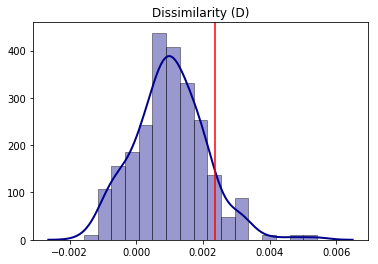

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


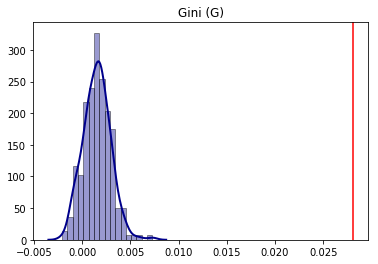

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


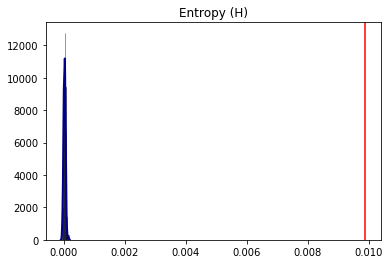

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


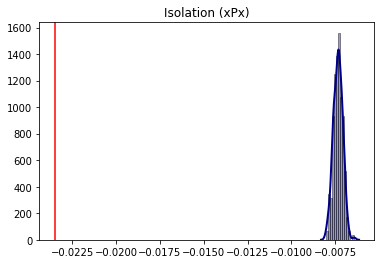

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


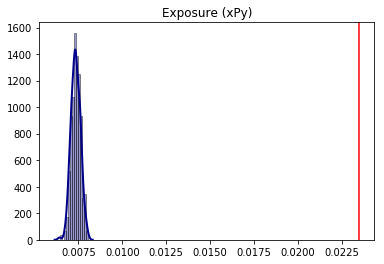

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


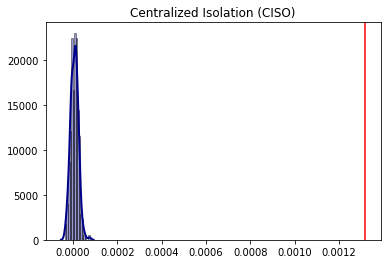

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


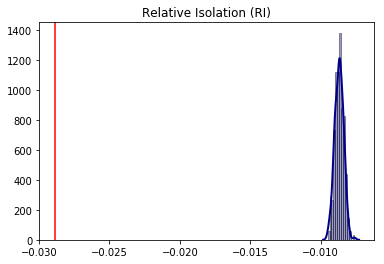

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


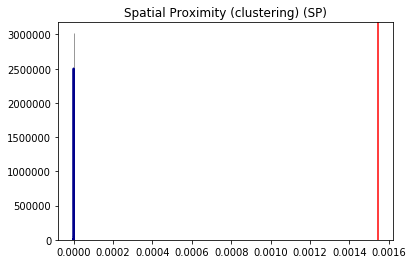

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


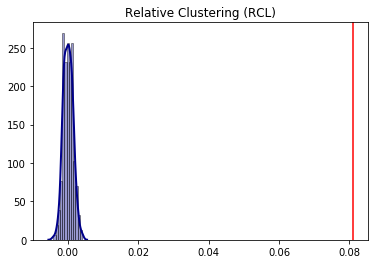

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


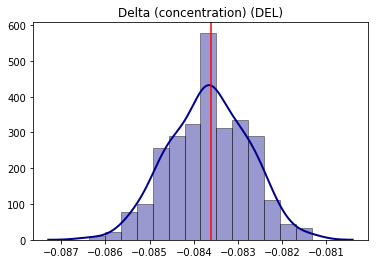

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


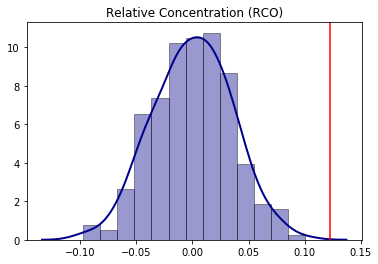

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


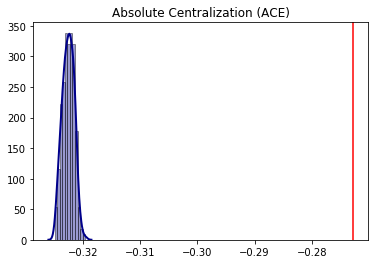

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


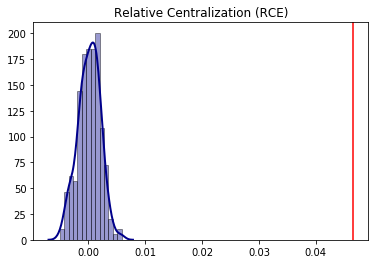

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


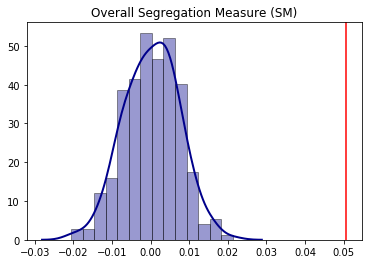

In [19]:
for i in range(len(simulations_A)):
    sns.distplot(np.array(simulations_A[i]) - np.array(simulations_B[i]), 
                 hist=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    #plt.axvline(0, color = 'green')
    plt.axvline(list(actual_values_A.values())[i] - list(actual_values_B.values())[i], color = 'red')
    plt.title(list(actual_values_A.keys())[i])
    plt.show()

# Comparing same county between two distincts periods in time: was a county, significantly, more or less segregated in 2010 than itself in 2000? 

In [20]:
census_2000 = pd.read_csv("data/std_2000_fullcount.csv", encoding = "ISO-8859-1", sep = ",")

# Some population data for 2000 came as decimals
census_2000['pop00']   = round(census_2000['pop00']).astype(int)
census_2000['nhblk00'] = round(census_2000['nhblk00']).astype(int)

#map_gpd = gpd.read_file('Tracts_grouped_by_County/01005.json')
#map_gpd = gpd.read_file('Tracts_grouped_by_County/38021.json')
map_gpd = gpd.read_file('Tracts_grouped_by_County/48371.json')
#map_gpd = gpd.read_file('Tracts_grouped_by_County/06065.json')

map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])

df_map1 = map_gpd.merge(census_2000, left_on = 'INTGEOID10', right_on = 'trtid10')[['geometry', 'nhblk00', 'pop00']]
df_map2 = map_gpd.merge(census_2010, left_on = 'INTGEOID10', right_on = 'trtid10')[['geometry', 'nhblk10', 'pop10']]

actual_values_A = calculate_segregation(df_map1, 'nhblk00', 'pop00')
actual_values_B = calculate_segregation(df_map2, 'nhblk10', 'pop10')

df_map1['year'] = '1'
df_map2['year'] = '2'

df_map1 = df_map1.rename(index=str, columns={'nhblk00': 'nhblk', 'pop00': 'pop'})
df_map2 = df_map2.rename(index=str, columns={'nhblk10': 'nhblk', 'pop10': 'pop'})

stacked_df_map = pd.concat([df_map1, df_map2], ignore_index=True)

aux_rand = list(np.random.choice(stacked_df_map.shape[0], stacked_df_map.shape[0], replace = False))

stacked_df_map['rand_year'] = stacked_df_map.year[aux_rand].reset_index()['year']
stacked_df_map['rand_pop'] = stacked_df_map['pop'][aux_rand].reset_index()['pop']
stacked_df_map['rand_nhblk'] = stacked_df_map.nhblk[aux_rand].reset_index()['nhblk']
stacked_df_map.head()

,geometry,nhblk,pop,year,rand_year,rand_pop,rand_nhblk
0,"POLYGON ((-102.208723 30.597961, -102.201603 3...",33,2857,1,1,3421,13
1,"POLYGON ((-102.208723 30.597961, -102.217266 3...",629,6429,1,1,2857,33
2,"POLYGON ((-102.884224 30.906389, -102.884225 3...",32,4102,1,2,5616,476
3,"POLYGON ((-102.891042 30.87504, -102.891048 30...",13,3421,1,1,4102,32
4,"POLYGON ((-102.208723 30.597961, -102.201603 3...",29,2383,2,2,4262,28


Random geometry approach.

In [21]:
stacked_df_map_RG_A = stacked_df_map.loc[stacked_df_map['rand_year'] == '1']
stacked_df_map_RG_B = stacked_df_map.loc[stacked_df_map['rand_year'] == '2']

simulations_A =  infer_segregation(stacked_df_map_RG_A, 'nhblk', 'pop', iterations = 250)
simulations_B =  infer_segregation(stacked_df_map_RG_B, 'nhblk', 'pop', iterations = 250)

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


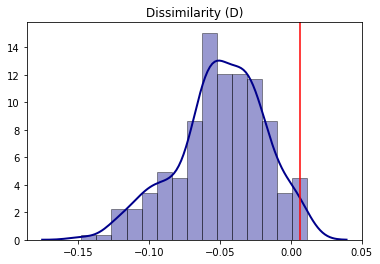

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


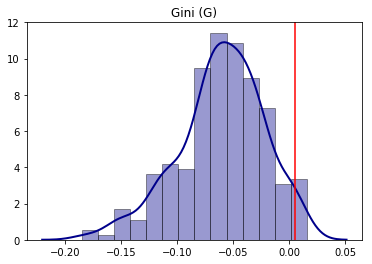

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


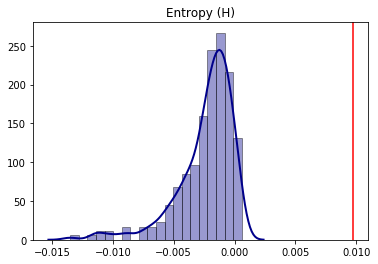

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


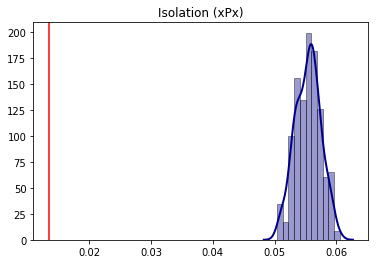

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


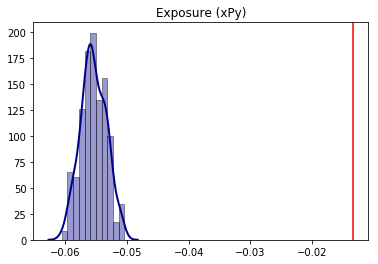

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


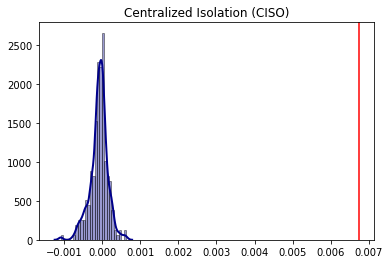

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


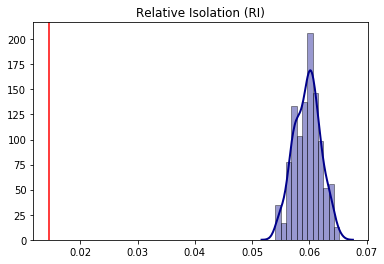

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


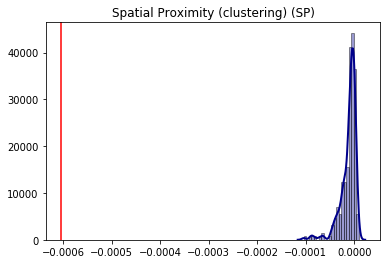

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


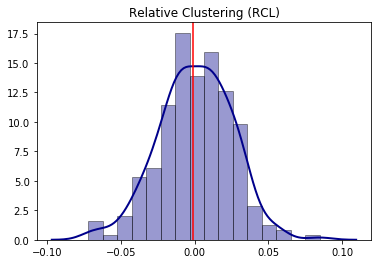

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


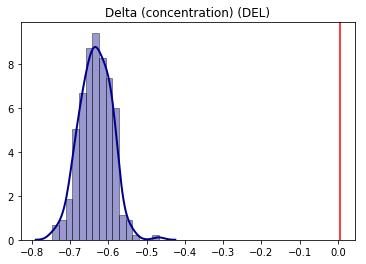

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


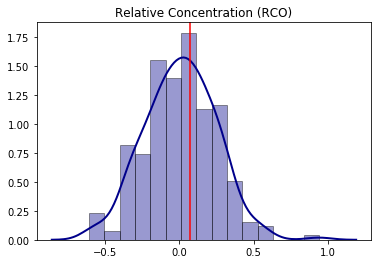

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


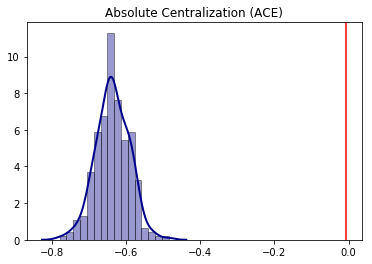

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


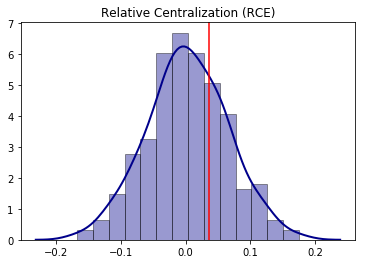

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


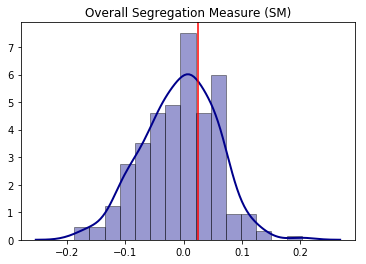

In [22]:
for i in range(len(simulations_A)):
    sns.distplot(np.array(simulations_A[i]) - np.array(simulations_B[i]), 
                 hist=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    #plt.axvline(0, color = 'green')
    plt.axvline(list(actual_values_A.values())[i] - list(actual_values_B.values())[i], color = 'red')
    plt.title(list(actual_values_A.keys())[i])
    plt.show()

Random data approach.

In [23]:
stacked_df_map_RD_A = stacked_df_map.loc[stacked_df_map['year'] == '1']
stacked_df_map_RD_B = stacked_df_map.loc[stacked_df_map['year'] == '2']

simulations_A =  infer_segregation(stacked_df_map_RD_A, 'rand_nhblk', 'rand_pop', iterations = 250)
simulations_B =  infer_segregation(stacked_df_map_RD_B, 'rand_nhblk', 'rand_pop', iterations = 250)

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


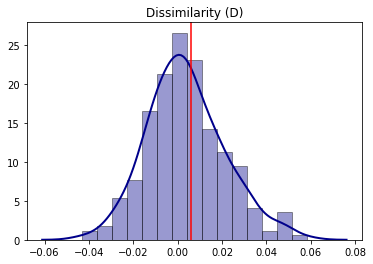

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


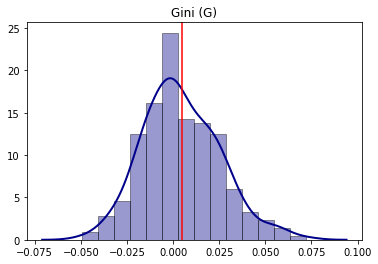

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


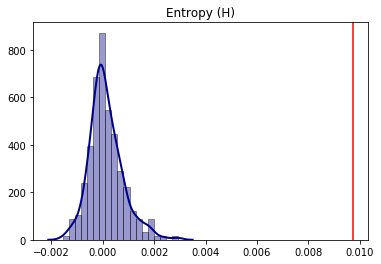

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


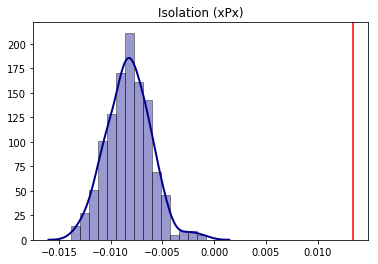

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


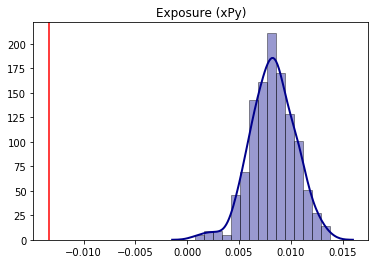

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


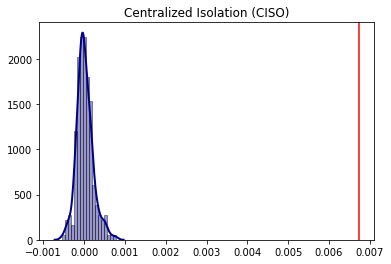

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


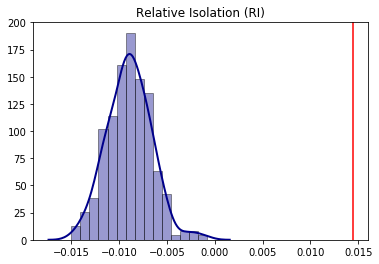

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


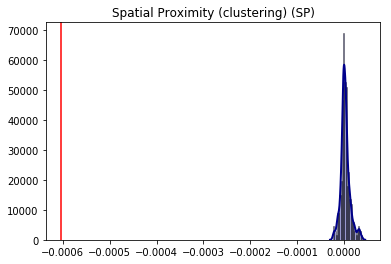

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


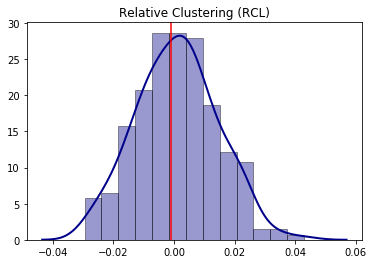

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


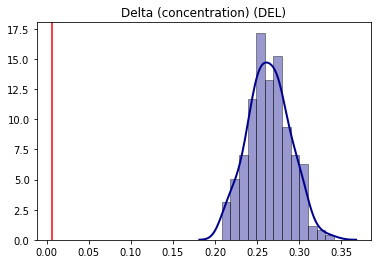

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


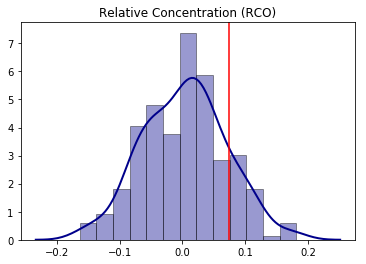

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


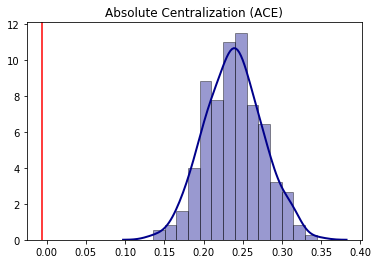

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


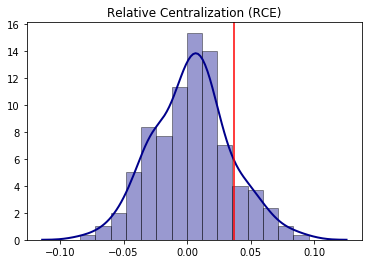

C:\Users\renan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


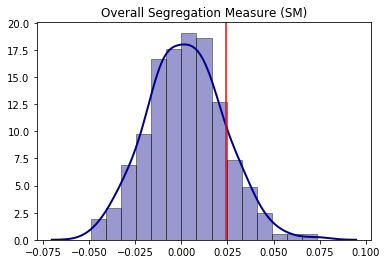

In [24]:
for i in range(len(simulations_A)):
    sns.distplot(np.array(simulations_A[i]) - np.array(simulations_B[i]), 
                 hist=True, 
                 color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2})
    #plt.axvline(0, color = 'green')
    plt.axvline(list(actual_values_A.values())[i] - list(actual_values_B.values())[i], color = 'red')
    plt.title(list(actual_values_A.keys())[i])
    plt.show()